## watsonx.ai challenge: news article Classification
The following notebook uses zero-shot text classification of news articles.  However it was not written using Prompt Patterns and would also benefit from using a more effective few-shot learning technique to improve model accuracy.

#### Apply what you've learned 
To complete the foundations of watsonx.ai technical series, we have provided a [notebook using generative AI to classify text in news articles](./news-article-classification.ipynb). Read through the notebook to understand how it approached the challenge of classifying text. Your mission is to rewrite the notebook by applying your new skills in prompt engineering to achieve a higher accuracy (already a high 90+%):

#### Need Ideas?
- Use the LangChain library's Prompt Template functionality?
- Implement a better few-shot learning technique to improve model accuracy?
- Perhaps be a rebel and show that a standard ML model performs better?

# Dataset
The dataset is collection of more than 1 million gathered from more than 2000 news sources by ComeToMyHead over one year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research and educational purposes. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html.

Each news article was tagged with one of four financial classes:

- world
- science_technology
- business
- sports

The dataset is broken into train and test sets of 120,000 and 7600 rows respectively. You will notice that only 2.5% of the dataset is used by default to limit the # of calls being made to watsonx.ai.

# Table of Contents

* [Step 1. Initialize system](#fm_initialize)
* [Step 2. Select the Model and Set Parameters](#fm_params)
* [Step 3. Prepare the Input Data](#fm_input)
* [Step 4. Run the Model Iterating over a Sample of the Dataset](#fm_iterate)
* [Step 5. Merge and Examine the Output Data](#fm_merge_examine)
* [Step 6. Analyze the Results](#fm_analyze)
* [Step 7. Submit Your Notebook for Review](#fm_submit_notebook)

<a id="fm_initialize"></a>
# Step 1. Initialize System

### 1.1 Import libraries
Import libraries and configure the system
We import the required libraries and IBM Generative AI modules.

In [2]:
import csv
from dotenv import load_dotenv
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.express as px

from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models import Model

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

### 1.2 Import config file

To support greater flexibility and configuration, this notebook uses a *config.json* file containing these options:
- `input_file_path`: The file path for the input data file for analysis in a CSV format.
- `output_file_path`: The file path for storing the classification data output.
- `input_value`: The header name of the input sentences from the input data CSV file.
- `original_class`: The header name of the original class from the input data CSV file.
- `classifications`: An array containing all categories.
- `misclassified_file_path`: The file path for storing the misclassified data.
- `output_file_header`: An array of headers to specify the output file column order.
- `sample_size`: The percentage of the input file to be sampled for processing.
- `params`: These additional parameters specify the model behavior.
	- `decoding_method`: This specifies the strategy for selecting tokens during the generation of the output text. This parameter can take on values of "greedy" or "sample", with "sample" as the default value if not specified.
	- `max_new_tokens`: The maximum number of new tokens to be generated. This parameter ranges from 1 to 1024, with a default value 20.
	- `min_new_tokens`: If stop sequences are given, they are ignored until the minimum tokens are generated. The parameter defaults to 0.
	- `random_seed`: Random number generator seed to use in sampling mode for experimental repeatability. The *random_seed* Must be greater than or equal to one.
	- `stop_sequences`: Stop sequences are one or more strings that will cause the text generation to stop when they are produced in the output.
	- `temperature`: The *temperature* modifies the next-token probabilities when running in sampling mode.
	- `top_k`: The number of highest probability vocabulary tokens to retain for top-k-filtering.
	- `top_p`: This parameter is similar to top_k, except the candidates to generate the next token are the most likely tokens with probabilities that sum to at least top_p. 

See the [wml sdk documentation](https://ibm.github.io/watson-machine-learning-sdk/foundation_models.html) for more paramteres.

In [9]:

with open('config.json', 'r') as f:
    json_data = json.load(f)

params_mapping = {
    'decoding_method':GenParams.DECODING_METHOD,
    'max_new_tokens':GenParams.MAX_NEW_TOKENS,
    'min_new_tokens':GenParams.MIN_NEW_TOKENS,
    'random_seed':GenParams.RANDOM_SEED,
    'stop_sequences':GenParams.STOP_SEQUENCES,
    'temperature':GenParams.TEMPERATURE,
    'top_k':GenParams.TOP_K,
    'top_p':GenParams.TOP_P
}

params = {params_mapping[key]:val for key, val in  json_data['params'].items()}

temp_path = json_data['temp_path']
input_file_path_temp = os.path.join(temp_path,"inputTemp.csv")
output_file_path_temp = os.path.join(temp_path,"outputTemp.csv")
os.makedirs(temp_path, exist_ok=True)

output_path = json_data['output_path']
output_file_path = os.path.join(output_path,json_data['output_file'])
os.makedirs(output_path, exist_ok=True)


<a id="fm_params"></a>
# Step 2. Select the Model and Set Parameters
In this step we select a model and set the parameters specific to the model to control the behavior.

In the default example, the only parameter passed to the models is decoding_method="greedy". When the *decoding_method* is set to "greedy", all generated text is included, so no additional parameters are needed.

You could explore using decoding_method="sample" and then set several additional parameters to control text generation. The *temperature* parameter adjusts the randomness of the model's output: setting it to 0.7 gives some randomness, but ensures the model isn't too random. The *min_new_tokens* and *max_new_tokens* parameters control the minimum and maximum number of new tokens the model can generate. The *top_k* and *top_p* parameters control how the model selects tokens from the predicted tokens, and are typically set to 50 and 1, respectively. With those settings, the model will choose the 50 most probable tokens and will not randomly select tokens.

In [4]:
# Ensure you copied the .env file that you created earlier into the same directory as this notebook
load_dotenv()
api_key = os.getenv("API_KEY", None)
ibm_cloud_url = os.getenv("IBM_CLOUD_URL", None)
project_id = os.getenv("PROJECT_ID", None)
if api_key is None or ibm_cloud_url is None or project_id is None:
    print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
else:
    creds = {
        "url": ibm_cloud_url,
        "apikey": api_key 
    }

FLAN = Model(
        model_id="google/flan-ul2",
        params=params,
        credentials=creds,
        project_id=project_id)

<a id="fm_input"></a>
# Step 3. Prepare the Input Data

## 3.1 Load configuration
Read input and specify indices are first column

In [5]:
input_file_path=json_data['input_file_path']
input_response = pd.read_csv(input_file_path, index_col=0)
input_response.head(5)

,label_value,subject,article,subject_article
label_name,,,,
business,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
business,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
business,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
business,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
business,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


## 3.2 Provide instructions to the model
Careful design of your instructions may seem easy to ignore but is a crucial step of Prompt Engineering.  As a test, try setting these instructions to an empty string "" to see how well the prompt performs without it

In [6]:
# Provide instructions to set context for the model
instructions = "Classify these news articles into one of these categories: "
instructions += ', '.join(json_data["classifications"]) + "\n\n"
print(instructions)

Classify these news articles into one of these categories: world, sports, business, science_technology




## 3.3 Review example prompt
We assemble one example of the prompt that will be passed to the LLM, consisting of the classification request combined with the text to be analyzed.

In [9]:
def generate_prompt(input_value):
    return instructions + input_value

input_value_header=json_data["input_value"]
original_class_header=json_data["original_class"]
with open(input_file_path, "r") as input_file:
    reader = csv.DictReader(input_file)
    for i, row in enumerate(reader):
        if i == 0:
            input_value = row[input_value_header]
            original_class = row[original_class_header]
            example_prompt = generate_prompt(input_value)
            print(example_prompt)

Classify these news articles into one of these categories: world, sports, business, science_technology

Wall St. Bears Claw Back Into the Black (Reuters): Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


<a id="fm_example_output"></a>
## 3.4 Review model response for prompt
We assemble one example of the prompt that will be passed to the LLM, consisting of the classification request combined with the text to be analyzed.

In [10]:
response = FLAN.generate_text(example_prompt)
model_class = response
input_text = example_prompt
input_text = input_text[len(instructions):len(input_text)]

print(f"The predicted class was '{model_class}'")
print(f"The actual class was '{original_class}'")

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10 inputs/s]

The predicted class was 'business'
The actual class was 'business'


<a id="fm_iterate"></a>
# Step 4. Run the Model Iterating over a Sample of the Dataset
We now iterate through the entire dataset, constructing prompts for each input text entry  and submitting them to the LLM. The sample_percent parameter specifies the percentage of the input text entries that will be submitted to the LLM

In [11]:
original_df = pd.read_csv(json_data['input_file_path'])
original_dataset_size = len(original_df)
sample_percent = json_data["sample_percent"]
sample_size = int(( sample_percent / 100) * original_dataset_size)
print(f"{sample_percent}% or {sample_size} of {original_dataset_size} samples will be evaluated")

df_sample = original_df.sample(n = sample_size, random_state=123456)
df_sample.head()

0.25% or 300 of 120000 samples will be evaluated


,label_name,label_value,subject,article,subject_article
93438,world,1,Minister stubs out smoke policy,THE Government #39;s plans for a partial ban o...,Minister stubs out smoke policy: THE Governmen...
114167,science_technology,4,"US university tells 80,000 to #39;ditch IE #39;","US university Penn State has advised its 80,00...","US university tells 80,000 to #39;ditch IE #3..."
80287,world,1,SLAIN FILMAKER: Dutch directory made films tha...,A Dutch filmmaker who outraged members of the ...,SLAIN FILMAKER: Dutch directory made films tha...
87030,business,3,Strike threat to Christmas post,"A union warns of ""very serious problems over C...",Strike threat to Christmas post: A union warns...
114708,sports,2,Miller routs rivals for sixth win,Bode Miller added another triumph to his spark...,Miller routs rivals for sixth win: Bode Miller...


In [ ]:
# Open the input and output CSV files
with open(input_file_path_temp, "w", newline="") as input_file_temp, open(output_file_path_temp, "w", newline="") as output_file:

    # Create CSV reader and writer objects
    writer_out = csv.DictWriter(output_file, fieldnames=json_data["output_file_header"])
    writer_temp = csv.DictWriter(input_file_temp, fieldnames=["original_class", "passage"])

    # Write the header row to the output CSV file
    writer_out.writeheader()
    writer_temp.writeheader()
    
    # Loop through each row in the input CSV file
    prompts_to_complete = []
    completed_prompts = []
    print("creating prompts...")
    for index, row in df_sample.iterrows():
        input_value = row[input_value_header]
        original_class = row[original_class_header]
        writer_temp.writerow({"original_class": original_class, "passage": input_value})
        prompt = generate_prompt(input_value)
        prompts_to_complete.append(prompt)
            
    num_of_prompts = len(prompts_to_complete)
    print(f"{num_of_prompts} prompts created")

    # generate async on all prompts
    responses = [FLAN.generate_text(prompt) for prompt in prompts_to_complete]
    for count, (input_text, classification) in enumerate(zip(prompts_to_complete, responses)):
        input_text = input_text[len(instructions):len(input_text)]
        writer_out.writerow({"index": count, "predicted_class": classification, "passage": input_text})


/Users/anthonystevens/miniconda3/envs/genai/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


creating prompts...
300 prompts created


Progress:  67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 202/300 [00:09<00:04, 21.53 inputs/s]

<a id="fm_merge_examine"></a>
# Step 5. Merge and Examine the Output Data

<a id="fm_merge_output"></a>
## 5.1 Merge output data
We next merge the input data with the processed output to create a single output file for analysis.

In [ ]:
# Read the first CSV file with original class and passage columns
df_input_temp = pd.read_csv(input_file_path_temp)

# Read the second CSV file with predicted class and passage columns
df_output_temp = pd.read_csv(output_file_path_temp)

# Merge the two dataframes based on the passage column
merged_df = pd.merge(df_input_temp, df_output_temp, on='passage')
merged_df = merged_df.drop_duplicates(subset='passage')

# Save the merged dataframe to a new CSV file
merged_df.to_csv(output_file_path, index=False)

<a id="fm_examine_output"></a>
## 5.2 Examine the model predictions
We can examine a small set of the combined data to compare the quality of the results. The data presented below shows the class (original sentiment) and the class predicted by the model (predicted sentiment). As can be seen, a majority of the classes in the small sample are predicted correctly and match. The combination of of the input and output data will allow us perform other analysis of the classification results. This is kept in memory as the *output_response* array for later access.

In [ ]:
output_response = pd.read_csv(output_file_path, index_col=None)
output_response.head(5)

<a id="fm_analyze"></a>
# Step 6. Analyze the Results

<a id="fm_compare"></a>
## 6.1 Comparison
Compare the predicted and original categories to find the percentage that exactly match. A percentage of 100% indicates all predictions match the original classifications.

In [48]:
reader = csv.reader(open(output_file_path))
test_dataset_size = len(list(reader))
# Skip the header
test_dataset_size = test_dataset_size - 1

matched_rows = 0
with open(output_file_path, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:

        # get the values of the two columns to compare
        column1 = row[0]
        column2 = row[3]
        if column1 == column2:
            matched_rows+=1
match_percent = (matched_rows / test_dataset_size) * 100
print(f"{match_percent:.2f}% rows matched")
print(f"{matched_rows} of {test_dataset_size} rows matched")

93.67% rows matched
281 of 300 rows matched


<a id="fm_post_processing"></a>
## 6.2 Post-process the dataset in preparation for performance analysis

Here, we post-process the dataset and generate sets of the original and predicted categories. We then create a file of the misclassified data that will be used in later analysis.

In [49]:
print(pd.unique(output_response['original_class']))
print(pd.unique(output_response['predicted_class']))

['world' 'science_technology' 'business' 'sports']
['science_technology' 'world' 'business' 'sports']


In [33]:
attribute_list=list(pd.unique(output_response['original_class']))
attribute_list

['sports', 'business', 'world', 'science_technology']

In [34]:
original_value_counts={}
predicted_value_counts={}
for i in attribute_list:
    original_value_counts['original_'+i]=output_response['original_class'].value_counts()[i]
    predicted_value_counts['predicted_'+i]=output_response['predicted_class'].value_counts()[i]
print('original_value_counts=',original_value_counts)

print('\predicted_value_counts=',predicted_value_counts)


original_value_counts= {'original_sports': 85, 'original_business': 58, 'original_world': 82, 'original_science_technology': 75}
\predicted_value_counts= {'predicted_sports': 87, 'predicted_business': 54, 'predicted_world': 77, 'predicted_science_technology': 82}


In [35]:
misclassified_file_path = os.path.join(output_path,json_data['misclassified_file_path'])

misclassified_rows = 0
with open(output_file_path, 'r') as input_file, open(misclassified_file_path, 'w', newline='') as output_file:

    # create the CSV reader and writer objects
    csv_reader = csv.reader(input_file)
    csv_writer = csv.writer(output_file)

    # loop through each row in the input file
    for row in csv_reader:

        # get the values of the two columns to compare
        column1 = row[0]
        column2 = row[3]

        # compare the two columns
        if column1 != column2:
            # write the row to the output file
            csv_writer.writerow(row)
            misclassified_rows+=1

misclassified_percent = (misclassified_rows / test_dataset_size) * 100
print(f"{misclassified_percent:.2f}% rows were misclassified")
print(f"{misclassified_rows} of {test_dataset_size} rows were misclassified")

6.00% rows were misclassified
18 of 300 rows were misclassified


<a id="fm_accuracy_data"></a>
## 6.3 Prepare to compute model accuracy
We create a copy of the *output_response* array named *dff* and then create separate vectors of the original (*y_test*) and predicted (*y_pred*) categories for analysis.

In [36]:
dff= output_response.copy()
y_test=dff['original_class']
y_pred=dff['predicted_class']

<a id="fm_accuracy"></a>
## 6.4 Compute model accuracy

Comparing the original and predicted categories and displaying the accuracy score as computed by scikit-learn should give an accuracy value that matches what was computed in section 6.1.

In [37]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('Accuracy of model ',accuracy_score(y_test,y_pred)*100,'%')
#this value should match with Match percentage estimated in comparison cell above

Accuracy of model  94.33333333333334 %


<a id="fm_confusion"></a>
## 6.5 Generate a confusion matrix
Next we compute and display the confusion matrix that characterizes the correct and incorrect categorizations and displays them graphically. Correct matches appear along a top-left to bottom-right diagonal. Cells with higher numbers of entries are shown in yellow ranging across the spectrum to lower numbers of entries shown in purple.

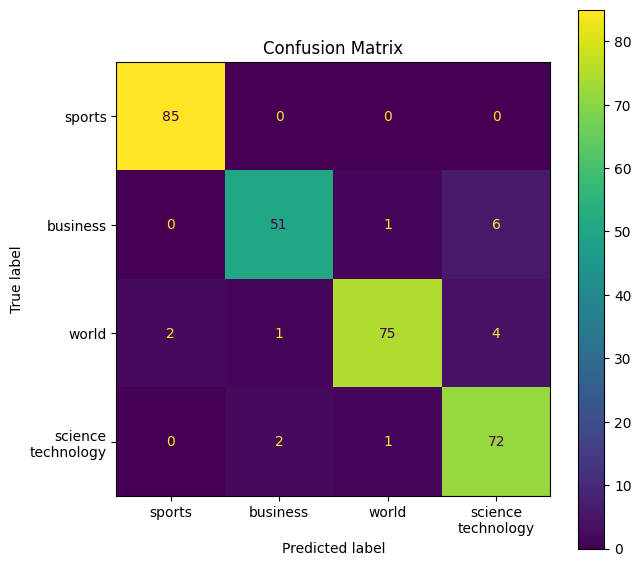

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
from textwrap import wrap
xy_label=['\n'.join(attribute.split('_')) for attribute in  attribute_list]
cm = confusion_matrix(y_test, y_pred,labels=attribute_list)
# print('Confusion Matrix \n',cm)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xy_label)
fig, ax = plt.subplots(figsize=(7,7))
plt.title('Confusion Matrix')
cm_display.plot(ax=ax)
# plt.setp(ax.get_xticklabels(), rotation=20)
plt.show()

<a id="fm_submit_notebook"></a>
##  Finished?
Submit your completed notebook to Anthony Stevens at apsteven@us.ibm.com.  

**NOTE:** Thanks to Mishal Dholakia as this notebook is based off his earlier work on a [Watsonx.ai classification notebook](https://github.ibm.com/Research-Notebooks/foundation-model/blob/main/01_Zero_shot_classification.ipynb).  You can also contact that by email at IBM.Research.JupyterLab@ibm.com.